<a href="https://colab.research.google.com/github/cuzmyk/data_mining/blob/main/pr11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая №11. Прогнозирование временных рядов, используя методы глубокого обучения**

# **Задание:**






## 1. Ознакомьтесь с библиотеками и их инструментарием
## 2. В контексте выбранного Вами набора данных, отберите несколько моделей глубокого обучения, обучите их на своих данных, после чего проведите сравнительный анализ.

## **Подготовка данных**

Используемый датасет https://www.kaggle.com/datasets/diegogaldino/brazil-wildfire-data-first-semester-2023


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import os

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_csv('Brazil_Fire_Incidents.csv')
df.head()

,id,latitude,longitude,datetime_gmt,satellite,municipality,state,biome,fire_risk
0,8c3be1cf-55a4-3d95-9e1d-6edbbb9985c9,-13.25160,-45.55090,2023-01-01 01:13:30,METOP-B,CORRENTINA,BAHIA,Cerrado,NaN
1,61d686ec-fc2f-3c5c-8cf1-ece94ec2feac,-13.24710,-45.53360,2023-01-01 01:13:30,METOP-B,CORRENTINA,BAHIA,Cerrado,NaN
2,1281243c-38f7-30db-92d8-31356fb06af4,-13.26891,-45.56372,2023-01-01 01:28:00,TERRA_M-M,CORRENTINA,BAHIA,Cerrado,23.8
3,3ce4a9d8-6d75-3722-b6fe-7e4847893273,-13.26745,-45.55385,2023-01-01 01:28:00,TERRA_M-M,CORRENTINA,BAHIA,Cerrado,20.0
4,682f75d4-40ef-38bf-abed-dfa1fc5b1688,-13.33733,-44.11688,2023-01-01 01:28:00,TERRA_M-M,SANTA MARIA DA VITÓRIA,BAHIA,Cerrado,7.0


In [ ]:
# Создание копии и удаление лишних колонок
drop = ['satellite','municipality', 'state', 'biome']
df = df.drop(columns=drop)

df.head()

,id,latitude,longitude,datetime_gmt,fire_risk
0,8c3be1cf-55a4-3d95-9e1d-6edbbb9985c9,-13.25160,-45.55090,2023-01-01 01:13:30,NaN
1,61d686ec-fc2f-3c5c-8cf1-ece94ec2feac,-13.24710,-45.53360,2023-01-01 01:13:30,NaN
2,1281243c-38f7-30db-92d8-31356fb06af4,-13.26891,-45.56372,2023-01-01 01:28:00,23.8
3,3ce4a9d8-6d75-3722-b6fe-7e4847893273,-13.26745,-45.55385,2023-01-01 01:28:00,20.0
4,682f75d4-40ef-38bf-abed-dfa1fc5b1688,-13.33733,-44.11688,2023-01-01 01:28:00,7.0


In [ ]:
df.isnull().sum()

,0
id,0
latitude,0
longitude,0
datetime_gmt,0
fire_risk,20101


In [ ]:
df = df.dropna(subset=['fire_risk'])
df.isnull().sum()

,0
id,0
latitude,0
longitude,0
datetime_gmt,0
fire_risk,0


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['fire_risk_scaled'] = scaler.fit_transform(df[['fire_risk']])

In [ ]:
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

look_back = 3  # Количество предыдущих временных шагов для прогнозирования
X, Y = create_dataset(df['fire_risk_scaled'].values, look_back)

In [ ]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Преобразование данных для LSTM (добавление размерности)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
print(X_train.shape, Y_train.shape)

(352136, 3, 1) (352136,)


## **1. Рекуррентная нейронная сеть (RNN)**

In [ ]:
# Построение модели
model_rnn = Sequential()
model_rnn.add(SimpleRNN(50, input_shape=(look_back, X_train.shape[2]), activation='tanh'))
model_rnn.add(Dense(X_train.shape[2]))
model_rnn.compile(loss='mean_squared_error', optimizer='adam')

# Обучение модели
history = model_rnn.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=15,
    validation_data=(X_test, Y_test),
    verbose=2
)

# Прогнозирование
train_predict_rnn = model_rnn.predict(X_train)
test_predict_rnn = model_rnn.predict(X_test)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
23476/23476 - 67s - 3ms/step - loss: 9.4713e-05 - val_loss: 1.1534e-04
Epoch 2/100
23476/23476 - 83s - 4ms/step - loss: 9.1695e-05 - val_loss: 1.0453e-04
Epoch 3/100
23476/23476 - 62s - 3ms/step - loss: 9.0662e-05 - val_loss: 1.0524e-04
Epoch 4/100
23476/23476 - 86s - 4ms/step - loss: 8.9972e-05 - val_loss: 1.0824e-04
Epoch 5/100
23476/23476 - 78s - 3ms/step - loss: 8.9042e-05 - val_loss: 1.0259e-04
Epoch 6/100
23476/23476 - 61s - 3ms/step - loss: 8.7971e-05 - val_loss: 1.0216e-04
Epoch 7/100
23476/23476 - 87s - 4ms/step - loss: 8.7489e-05 - val_loss: 1.0186e-04
Epoch 8/100
23476/23476 - 84s - 4ms/step - loss: 8.7387e-05 - val_loss: 1.0454e-04
Epoch 9/100
23476/23476 - 74s - 3ms/step - loss: 8.7190e-05 - val_loss: 1.0169e-04
Epoch 10/100
23476/23476 - 84s - 4ms/step - loss: 8.7012e-05 - val_loss: 1.0062e-04
Epoch 11/100
23476/23476 - 65s - 3ms/step - loss: 8.6934e-05 - val_loss: 1.0049e-04
Epoch 12/100
23476/23476 - 66s - 3ms/step - loss: 8.6832e-05 - val_loss: 1.0177e-04
E



1. **Вычисление метрики RMSE**:



  - **Обратите внимание**: Перед вычислением метрики мы приводим предсказанные значения и истинные значения к исходному масштабу с помощью `inverse_transform`, чтобы метрика была интерпретируема.
  - **RMSE (корень из среднеквадратичной ошибки)** оценивает среднее отклонение прогнозов от истинных значений.

In [ ]:
# Преобразование предсказанных и фактических значений обратно к исходному масштабу
train_predict_rnn = scaler.inverse_transform(train_predict_rnn.reshape(-1, 1))
Y_train_actual_rnn = scaler.inverse_transform(Y_train.reshape(-1, 1))
test_predict_rnn = scaler.inverse_transform(test_predict_rnn.reshape(-1, 1))
Y_test_actual_rnn = scaler.inverse_transform(Y_test.reshape(-1, 1))

In [ ]:
# Вычисление RMSE
from sklearn.metrics import mean_squared_error

train_score_rnn = np.sqrt(mean_squared_error(Y_train_actual_rnn, train_predict_rnn))
test_score_rnn = np.sqrt(mean_squared_error(Y_test_actual_rnn, test_predict_rnn))
print(f'RMSE на обучающем наборе: {train_score_rnn:.2f}')
print(f'RMSE на тестовом наборе: {test_score_rnn:.2f}')

RMSE на обучающем наборе: 62.39
RMSE на тестовом наборе: 68.02


2. **Построение графика потерь во время обучения**:

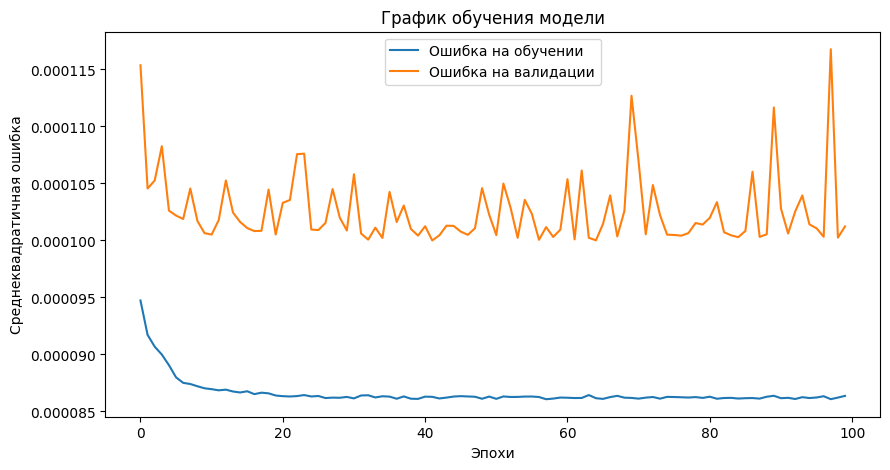

In [ ]:
# Построение графика потерь
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Ошибка на обучении')
plt.plot(history.history['val_loss'], label='Ошибка на валидации')
plt.title('График обучения модели')
plt.xlabel('Эпохи')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

3. **Построение графика результатов моделирования**:

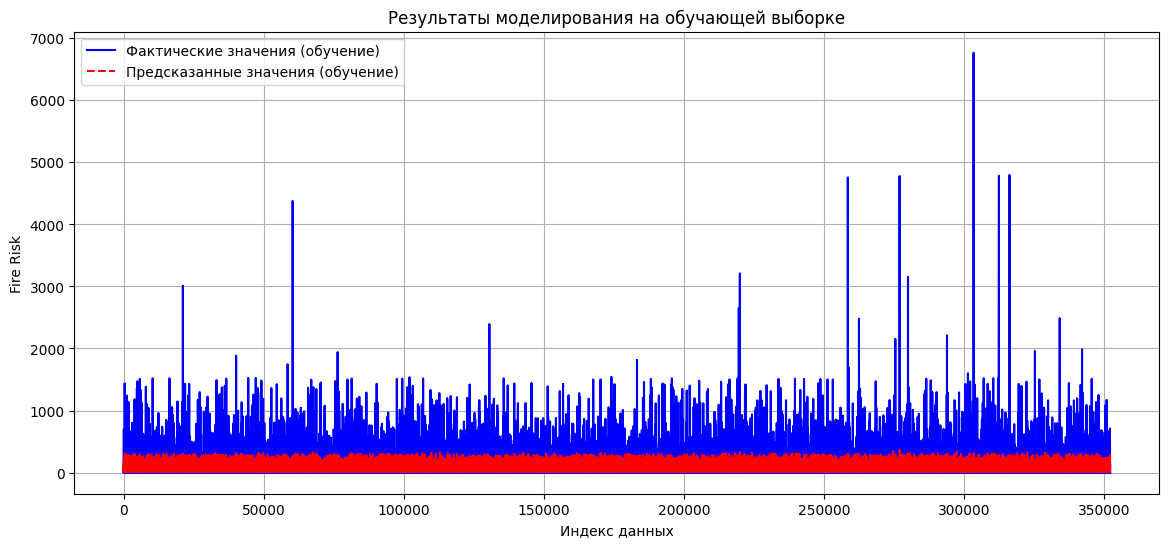

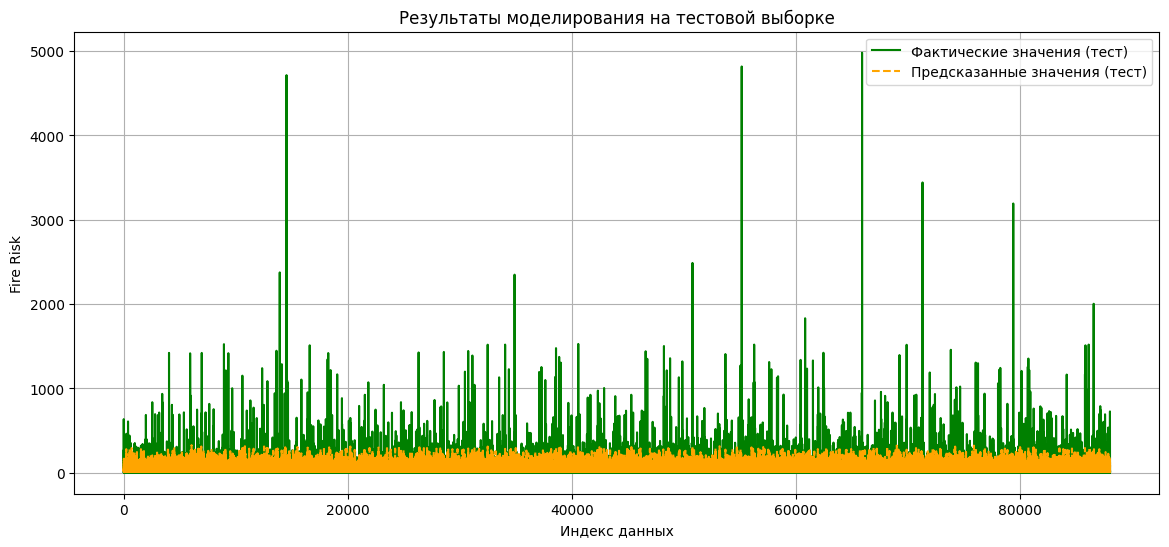

In [ ]:
import matplotlib.pyplot as plt

# Построение графика для обучающей выборки
plt.figure(figsize=(14, 6))
plt.plot(range(len(Y_train_actual_rnn)), Y_train_actual_rnn, label='Фактические значения (обучение)', color='blue')
plt.plot(range(len(train_predict_rnn)), train_predict_rnn, label='Предсказанные значения (обучение)', color='red', linestyle='--')
plt.title('Результаты моделирования на обучающей выборке')
plt.xlabel('Индекс данных')
plt.ylabel('Fire Risk')
plt.legend()
plt.grid(True)
plt.show()

# Построение графика для тестовой выборки
plt.figure(figsize=(14, 6))
plt.plot(range(len(Y_test_actual_rnn)), Y_test_actual_rnn, label='Фактические значения (тест)', color='green')
plt.plot(range(len(test_predict_rnn)), test_predict_rnn, label='Предсказанные значения (тест)', color='orange', linestyle='--')
plt.title('Результаты моделирования на тестовой выборке')
plt.xlabel('Индекс данных')
plt.ylabel('Fire Risk')
plt.legend()
plt.grid(True)
plt.show()

## **2. Долгая краткосрочная память (LSTM)**




In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Создание модели
model_lstm = Sequential()
model_lstm.add(LSTM(100, return_sequences=True, input_shape=(look_back, X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(25))
model_lstm.add(Dense(X_train.shape[2]))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# Обучение модели
history_lstm = model_lstm.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, Y_test),
    verbose=2
)

# Прогнозирование
train_predict_lstm = model_lstm.predict(X_train)
test_predict_lstm = model_lstm.predict(X_test)


Epoch 1/50
11005/11005 - 110s - 10ms/step - loss: 9.1906e-05 - val_loss: 1.0060e-04
Epoch 2/50
11005/11005 - 142s - 13ms/step - loss: 8.6983e-05 - val_loss: 1.0396e-04
Epoch 3/50
11005/11005 - 141s - 13ms/step - loss: 8.6058e-05 - val_loss: 9.9883e-05
Epoch 4/50
11005/11005 - 105s - 10ms/step - loss: 8.5852e-05 - val_loss: 1.0057e-04
Epoch 5/50
11005/11005 - 144s - 13ms/step - loss: 8.5519e-05 - val_loss: 1.0156e-04
Epoch 6/50
11005/11005 - 139s - 13ms/step - loss: 8.5136e-05 - val_loss: 1.0121e-04
Epoch 7/50
11005/11005 - 103s - 9ms/step - loss: 8.5106e-05 - val_loss: 9.9288e-05
Epoch 8/50
11005/11005 - 141s - 13ms/step - loss: 8.4877e-05 - val_loss: 1.0306e-04
Epoch 9/50
11005/11005 - 145s - 13ms/step - loss: 8.4970e-05 - val_loss: 9.9796e-05
Epoch 10/50
11005/11005 - 140s - 13ms/step - loss: 8.4745e-05 - val_loss: 1.0282e-04
Epoch 11/50
11005/11005 - 145s - 13ms/step - loss: 8.4830e-05 - val_loss: 9.9138e-05
Epoch 12/50
11005/11005 - 140s - 13ms/step - loss: 8.4695e-05 - val_loss: 9

In [ ]:
# Возвращение данных в исходный масштаб
train_predict_lstm = scaler.inverse_transform(train_predict_rnn.reshape(-1, 1))
Y_train_actual_lstm = scaler.inverse_transform(Y_train.reshape(-1, 1))
test_predict_lstm = scaler.inverse_transform(test_predict_rnn.reshape(-1, 1))
Y_test_actual_lstm = scaler.inverse_transform(Y_test.reshape(-1, 1))
# Вычисление RMSE
train_score_lstm = np.sqrt(mean_squared_error(Y_train_actual_lstm, train_predict_lstm))
test_score_lstm = np.sqrt(mean_squared_error(Y_test_actual_lstm, test_predict_lstm))
print(f'RMSE на обучающем наборе: {train_score_lstm:.2f}')
print(f'RMSE на тестовом наборе: {test_score_lstm:.2f}')

RMSE на обучающем наборе: 395733.42
RMSE на тестовом наборе: 395949.78


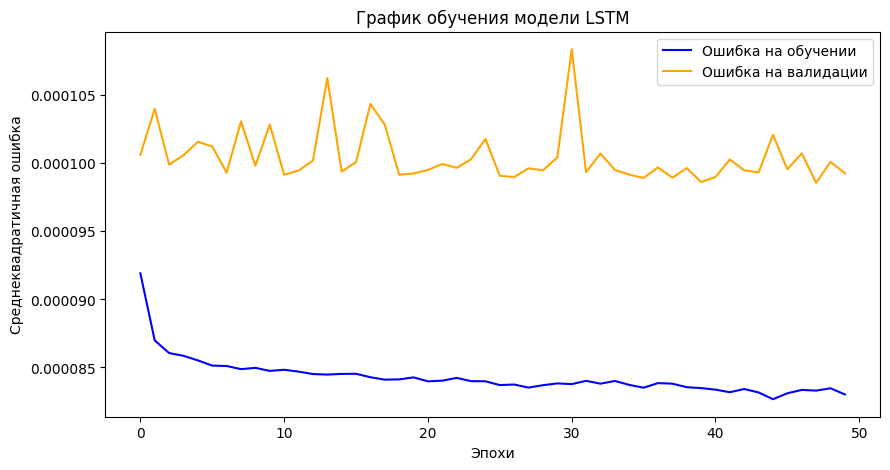

In [ ]:
# Построение графика потерь
plt.figure(figsize=(10, 5))
plt.plot(history_lstm.history['loss'], label='Ошибка на обучении', color='blue')
plt.plot(history_lstm.history['val_loss'], label='Ошибка на валидации', color='orange')
plt.title('График обучения модели LSTM')
plt.xlabel('Эпохи')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

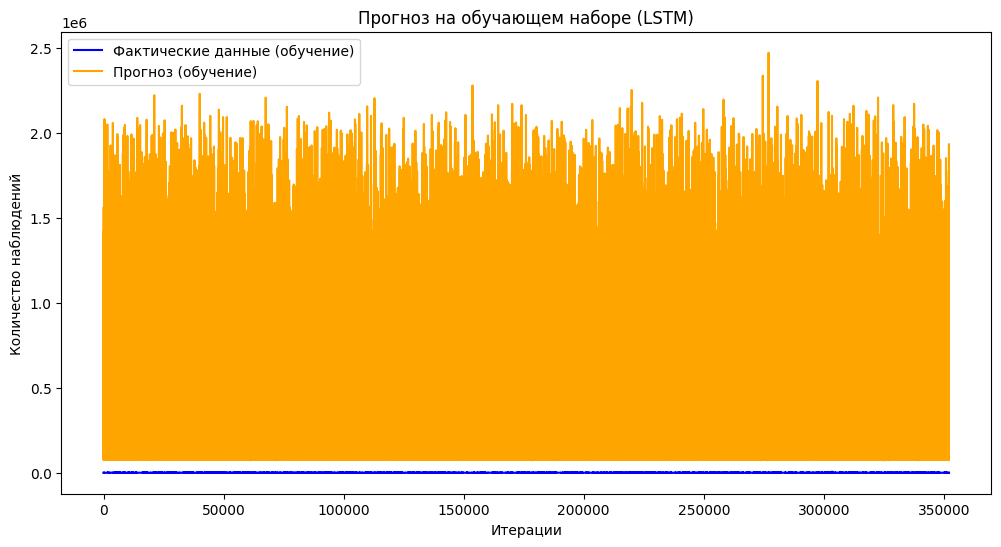

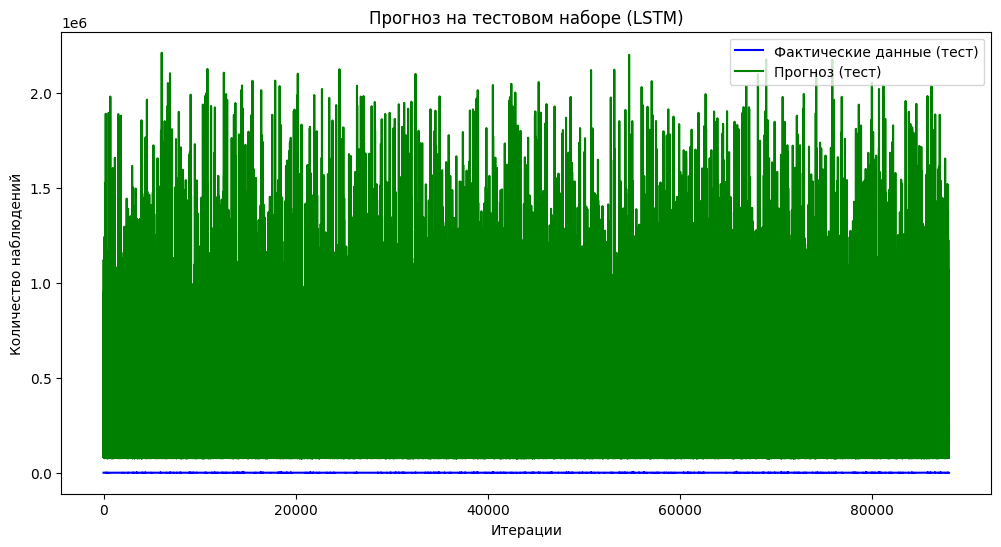

In [ ]:
# Визуализация результатов на обучающем наборе
plt.figure(figsize=(12, 6))
plt.plot(Y_train_actual_lstm[:, 0], label='Фактические данные (обучение)', color='blue')
plt.plot(train_predict_lstm[:, 0], label='Прогноз (обучение)', color='orange')
plt.title('Прогноз на обучающем наборе (LSTM)')
plt.xlabel('Итерации')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

# Визуализация результатов на тестовом наборе
plt.figure(figsize=(12, 6))
plt.plot(Y_test_actual_lstm[:, 0], label='Фактические данные (тест)', color='blue')
plt.plot(test_predict_lstm[:, 0], label='Прогноз (тест)', color='green')
plt.title('Прогноз на тестовом наборе (LSTM)')
plt.xlabel('Итерации')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

## **3. Управляемые рекуррентные блоки (GRU)**



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
# Создание модели
model_gru = Sequential()
model_gru.add(GRU(100, return_sequences=True, input_shape=(look_back, X_train.shape[2])))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(50, return_sequences=True))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(25))
model_gru.add(Dense(X_train.shape[2]))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

# Обучение модели
history_gru = model_gru.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, Y_test),
    verbose=2
)

# Прогнозирование
train_predict_gru = model_gru.predict(X_train)
test_predict_gru = model_gru.predict(X_test)

Epoch 1/50
11005/11005 - 180s - 16ms/step - loss: 9.3692e-05 - val_loss: 1.0546e-04
Epoch 2/50
11005/11005 - 147s - 13ms/step - loss: 8.7681e-05 - val_loss: 1.0123e-04
Epoch 3/50
11005/11005 - 142s - 13ms/step - loss: 8.6358e-05 - val_loss: 1.0009e-04
Epoch 4/50
11005/11005 - 128s - 12ms/step - loss: 8.5981e-05 - val_loss: 9.9869e-05
Epoch 5/50
11005/11005 - 142s - 13ms/step - loss: 8.5578e-05 - val_loss: 1.0096e-04
Epoch 6/50
11005/11005 - 137s - 12ms/step - loss: 8.5535e-05 - val_loss: 1.0160e-04
Epoch 7/50
11005/11005 - 143s - 13ms/step - loss: 8.4950e-05 - val_loss: 9.9453e-05
Epoch 8/50
11005/11005 - 143s - 13ms/step - loss: 8.5327e-05 - val_loss: 9.9439e-05
Epoch 9/50
11005/11005 - 141s - 13ms/step - loss: 8.5110e-05 - val_loss: 1.0017e-04
Epoch 10/50
11005/11005 - 150s - 14ms/step - loss: 8.4832e-05 - val_loss: 1.0007e-04
Epoch 11/50
11005/11005 - 141s - 13ms/step - loss: 8.5101e-05 - val_loss: 1.0194e-04
Epoch 12/50
11005/11005 - 122s - 11ms/step - loss: 8.4877e-05 - val_loss: 

In [ ]:
# Возвращение данных в исходный масштаб
train_predict_gru = scaler.inverse_transform(train_predict_rnn.reshape(-1, 1))
Y_train_actual_gru = scaler.inverse_transform(Y_train.reshape(-1, 1))
test_predict_gru = scaler.inverse_transform(test_predict_rnn.reshape(-1, 1))
Y_test_actual_gru = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Вычисление RMSE
train_score_gru = np.sqrt(mean_squared_error(Y_train_actual_gru, train_predict_gru))
test_score_gru = np.sqrt(mean_squared_error(Y_test_actual_gru, test_predict_gru))
print(f'RMSE на обучающем наборе: {train_score_gru:.2f}')
print(f'RMSE на тестовом наборе: {test_score_gru:.2f}')

RMSE на обучающем наборе: 395733.42
RMSE на тестовом наборе: 395949.78


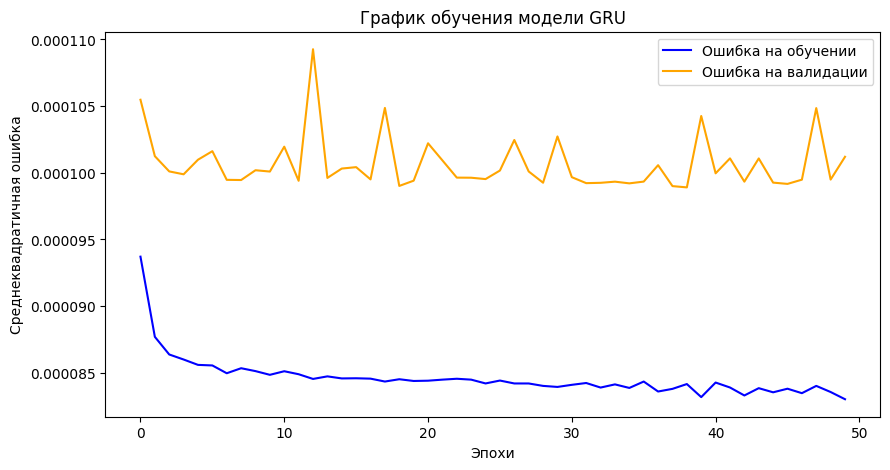

In [ ]:
# Построение графика потерь
plt.figure(figsize=(10, 5))
plt.plot(history_gru.history['loss'], label='Ошибка на обучении', color='blue')
plt.plot(history_gru.history['val_loss'], label='Ошибка на валидации', color='orange')
plt.title('График обучения модели GRU')
plt.xlabel('Эпохи')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

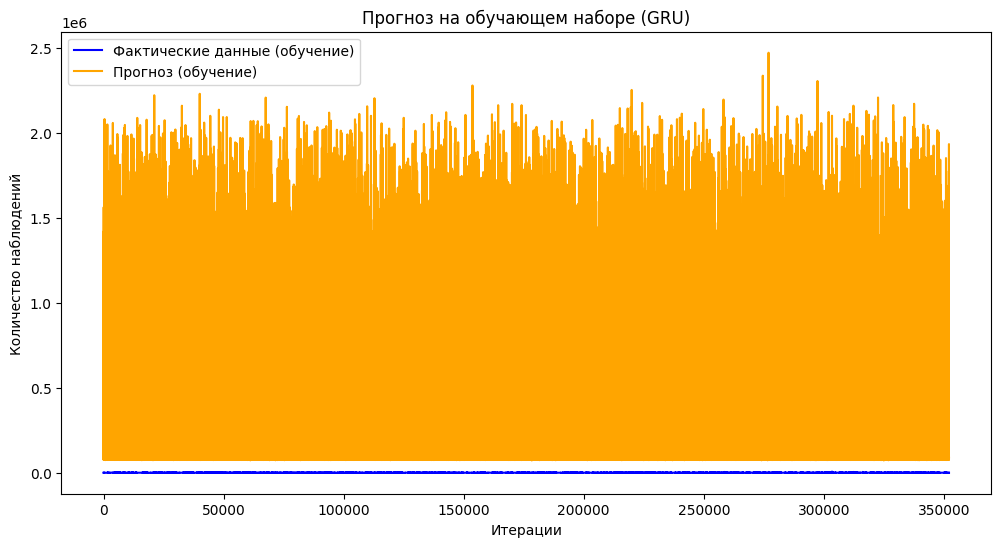

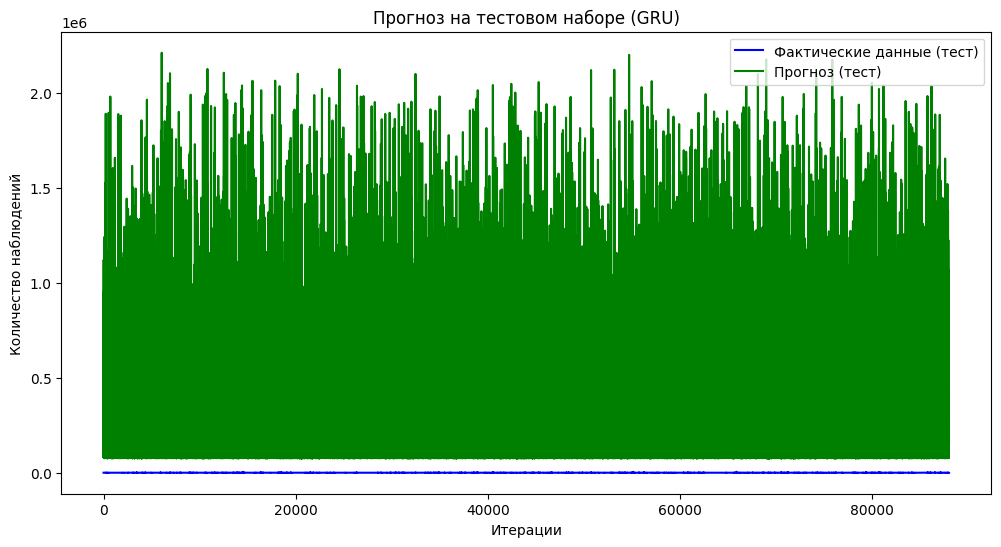

In [ ]:
# Визуализация результатов на обучающем наборе
plt.figure(figsize=(12, 6))
plt.plot(Y_train_actual_gru[:, 0], label='Фактические данные (обучение)', color='blue')
plt.plot(train_predict_gru[:, 0], label='Прогноз (обучение)', color='orange')
plt.title('Прогноз на обучающем наборе (GRU)')
plt.xlabel('Итерации')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

# Визуализация результатов на тестовом наборе
plt.figure(figsize=(12, 6))
plt.plot(Y_test_actual_gru[:, 0], label='Фактические данные (тест)', color='blue')
plt.plot(test_predict_gru[:, 0], label='Прогноз (тест)', color='green')
plt.title('Прогноз на тестовом наборе (GRU)')
plt.xlabel('Итерации')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

### **4. N-BEATS**

In [ ]:
# Установка пакета nbeats-keras
!pip install nbeats-keras

INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 18.5 MB/s et

In [ ]:
from nbeats_keras.model import NBeatsNet
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
# Параметры модели
input_dim = X_train.shape[2]  # Количество признаков
backcast_length = look_back  # Длина истории
forecast_length = X_train.shape[2]  # Прогнозируем все признаки, а не одно значение
num_epochs = 5  # Для тестирования можно уменьшить количество эпох

# Создание упрощенной модели N-BEATS
model_nbeats = NBeatsNet(
    input_dim=input_dim,
    backcast_length=backcast_length,
    forecast_length=forecast_length,  # Прогнозируем все признаки
    stack_types=(NBeatsNet.GENERIC_BLOCK,),  # Один блок
    nb_blocks_per_stack=1,  # Уменьшаем количество блоков
    thetas_dim=(4,),  # Уменьшаем размер тета
    share_weights_in_stack=False,  # Упростим модель
    hidden_layer_units=16  # Уменьшаем количество нейронов
)

# Оптимизатор
optimizer = Adam(learning_rate=0.001)

# Компиляция модели с run_eagerly=True для отладки
model_nbeats.compile(loss='mean_squared_error', optimizer=optimizer, run_eagerly=True)

# Проверьте размерность данных
print("Размер X_train:", X_train.shape)
print("Размер Y_train:", Y_train.shape)

# Индексация на 30% данных
X_train_subset = X_train[:int(0.1 * len(X_train))]
Y_train_subset = Y_train[:int(0.1 * len(Y_train))]

# Проверьте размерность подмножества данных
print("Размер X_train_subset:", X_train_subset.shape)
print("Размер Y_train_subset:", Y_train_subset.shape)

# Обучение модели на 30% данных
history_nbeats = model_nbeats.fit(
    X_train_subset,  # Используем только 30% данных для обучения
    Y_train_subset,  # Используем только 30% целевых данных
    validation_data=(X_test, Y_test),
    epochs=num_epochs,
    batch_size=8,  # Размер батча уменьшен
    verbose=2
)

# Прогнозирование
train_predict_nbeats = model_nbeats.predict(X_train_subset)
test_predict_nbeats = model_nbeats.predict(X_test)

Размер X_train: (352136, 3, 1)
Размер Y_train: (352136,)
Размер X_train_subset: (35213, 3, 1)
Размер Y_train_subset: (35213,)
Epoch 1/5
4402/4402 - 352s - loss: 1.3394e-04 - val_loss: 1.5506e-04 - 352s/epoch - 80ms/step
Epoch 2/5
4402/4402 - 348s - loss: 1.3357e-04 - val_loss: 1.5194e-04 - 348s/epoch - 79ms/step
Epoch 3/5
4402/4402 - 345s - loss: 1.3357e-04 - val_loss: 1.5551e-04 - 345s/epoch - 78ms/step
Epoch 4/5
4402/4402 - 346s - loss: 1.3355e-04 - val_loss: 1.5263e-04 - 346s/epoch - 79ms/step
Epoch 5/5
4402/4402 - 338s - loss: 1.3330e-04 - val_loss: 1.5113e-04 - 338s/epoch - 77ms/step
2752/2752 [==============================] - 23s 8ms/step


In [ ]:
# Прогнозирование и восстановление масштаба данных
train_predict_nbeats_reshaped = train_predict_nbeats.reshape(-1, X_train.shape[2])  # Преобразование в 2D (по числу признаков)
train_predict_nbeats_inversed = scaler.inverse_transform(train_predict_nbeats_reshaped)

Y_train_actual = Y_train_subset.reshape(-1, X_train.shape[2])  # Преобразование целевого массива в нужный формат
Y_train_actual_inversed = scaler.inverse_transform(Y_train_actual)

test_predict_nbeats_reshaped = test_predict_nbeats.reshape(-1, X_train.shape[2])  # Преобразование в 2D
test_predict_nbeats_inversed = scaler.inverse_transform(test_predict_nbeats_reshaped)

Y_test_actual = Y_test.reshape(-1, X_train.shape[2])  # Преобразование целевого массива
Y_test_actual_inversed = scaler.inverse_transform(Y_test_actual)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Вычисление метрик ошибки
train_mse = mean_squared_error(Y_train_actual_inversed, train_predict_nbeats_inversed)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(Y_train_actual_inversed, train_predict_nbeats_inversed)

print('Метрики на обучающей выборке:')
print(f'MSE: {train_mse:.2f}')
print(f'RMSE: {train_rmse:.2f}')
print(f'MAE: {train_mae:.2f}')

test_mse = mean_squared_error(Y_test_actual_inversed, test_predict_nbeats_inversed)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(Y_test_actual_inversed, test_predict_nbeats_inversed)

print('\nМетрики на тестовой выборке:')
print(f'MSE: {test_mse:.2f}')
print(f'RMSE: {test_rmse:.2f}')
print(f'MAE: {test_mae:.2f}')

Метрики на обучающей выборке:
MSE: 5603.15
RMSE: 74.85
MAE: 41.08

Метрики на тестовой выборке:
MSE: 6501.24
RMSE: 80.63
MAE: 41.20


Сравнение рассмотренных моделей

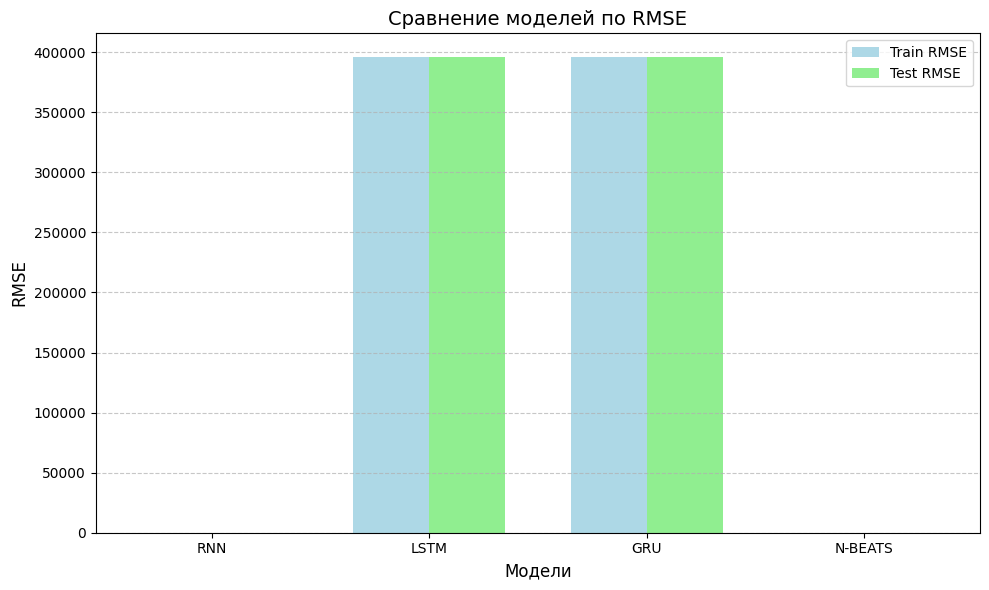

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Названия моделей
models = ['RNN', 'LSTM', 'GRU', 'N-BEATS']

# Метрики
train_rmse = [train_score_rnn, train_score_lstm, train_score_gru, train_rmse]  # RMSE на обучении
test_rmse = [test_score_rnn, test_score_lstm, test_score_gru, test_rmse]       # RMSE на тесте

bar_width = 0.35

x = np.arange(len(models))

plt.figure(figsize=(10, 6))

plt.bar(x - bar_width / 2, train_rmse, width=bar_width, label='Train RMSE', color='lightblue')
plt.bar(x + bar_width / 2, test_rmse, width=bar_width, label='Test RMSE', color='lightgreen')

plt.xlabel('Модели', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Сравнение моделей по RMSE', fontsize=14)
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
